# Autocodificador con sparsidad 

El siguiente autocodificador se creo bajo la idea de reducir la dimensionalidad para una  base de datos de alta dimensión, a diferencia de un autocodificador tradicional en el cual se van reduciendo el número de neuronas gradualmente a manera de "embudo" la arquitectura de esté autocodifacodr tiene un cambio pequeño pero significativo.

Cuando en un autocodificador clásico se llega a la representación latente más comprimida la dimensión de este vector latente es igual al número de neuronas del espacio latente, tipicamnete la dimensión latente es más pequeña que la dimensión de los datos de entrada así logrando reducir la dimensión de los datos, está representación latente se encuentra en la mitad de nuestro autocodificador y dependiendo del tipo de datos de entrada se seleccionan las funciones de costo, las cuales son normalmente una de regularización y de reconstrucción, ya que el objetivo al construir un autocodificador es lograr reproducir los datos de entrada.

En este autocodificador tenemos  un espacio latente de la misma dimensión que los datos de entrada, lo cual no tendría sentido ya que no se está reduciendo la dimensionalidad pero añadimos un término de regularización a la función de costo el cual es la norma L2 de el vector latente para de esta fortma lograr que la salida de algunas neuronas se acerque o se haga cero, de esta manera se lográ reducir la dimensionalidad de manera implicita ya que auqellas  neuronas que esten cerca del cero o sean cero, podemos considerarlas como si no estuvieran ahí (ya que no aportan información significativa a la representación latente) por lo que podemos "cortarlas", de esta manera reduciendo las dimensiones de la información de entrada.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import datetime
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Liver_GSE14520_U133A.csv')
data.head()


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM362958.CEL.gz,HCC,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,GSM362959.CEL.gz,HCC,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,GSM362960.CEL.gz,HCC,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,GSM362964.CEL.gz,HCC,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,GSM362965.CEL.gz,HCC,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


In [5]:
data.drop(['samples','type'], axis=1, inplace=True)
data.head()

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,3.654116,3.804983,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,5.137159,8.622475,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,4.515175,12.681439,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,5.192624,11.759412,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,4.961625,10.318552,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


In [7]:
# Normalización de los datos
data = data.values.astype(np.float32)
data = StandardScaler().fit_transform(data)

In [9]:
# Hiperparametros de la red
input_dim = data.shape[1]
latent_dim = input_dim
learning_rate = 0.0001
l1_norm_weight = 1e-5
recon_weight = 1
negative_slope = 0.1
mini_batch_size = 51

In [11]:
# encoder
input_layer = keras.Input(shape=(input_dim,))
latent_space = layers.Dense(input_dim, name="latent_space")(input_layer)
latent_space =  LeakyReLU(negative_slope)(latent_space)

In [13]:
encoder = keras.Model(input_layer, latent_space, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 22277)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 22277)          │   496,287,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 22277)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,287,006 (1.85 GB)

 Trainable params: 496,287,006 (1.85 GB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# decoder
latent_input = keras.Input(shape=(input_dim,), name="decoder_input")
reconstruction = layers.Dense(input_dim, name="decoder_output")(latent_input)
reconstruction = layers.LeakyReLU(negative_slope)(reconstruction)

In [17]:
decoder = keras.Model(latent_input, reconstruction, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 22277)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 22277)          │   496,287,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 22277)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,287,006 (1.85 GB)

 Trainable params: 496,287,006 (1.85 GB)

 Non-trainable params: 0 (0.00 B)

In [19]:
class Autoencoder(keras.Model):
  def __init__(self, encoder, decoder, l1_norm_weight, recon_weight, **kwargs):
    super(Autoencoder, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.l1_norm_weight = l1_norm_weight
    self.recon_weight = recon_weight
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.l1_norm_loss_tracker = keras.metrics.Mean(name="l1_norm_loss")

  def call(self, inputs):
      encoded = self.encoder(inputs)
      decoded = self.decoder(encoded)
      return decoded

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.l1_norm_loss_tracker,
    ]

  def train_step(self, data):
    if isinstance(data, tuple):
        data = data[0]

    with tf.GradientTape() as tape:
        latent_rep = self.encoder(data)
        l1_norm_loss = tf.reduce_sum(tf.abs(latent_rep))*self.l1_norm_weight
        x_reconstructed = self.decoder(latent_rep)
        reconstruction_loss = tf.reduce_mean(
                    tf.square(data - x_reconstructed)
                )*self.recon_weight

        total_loss = l1_norm_loss + reconstruction_loss
    grads =  tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.l1_norm_loss_tracker.update_state(l1_norm_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "l1_norm_loss": self.l1_norm_loss_tracker.result(),
    }







In [21]:
#implementar un dataset de tensorflow
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(buffer_size=357).batch(mini_batch_size)

In [23]:
autoencoder = Autoencoder(encoder, decoder, l1_norm_weight, recon_weight)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate))
history = autoencoder.fit(dataset, epochs=15)




Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - l1_norm_loss: 4.5337 - loss: 5.6550 - reconstruction_loss: 1.1213
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - l1_norm_loss: 3.4218 - loss: 4.4439 - reconstruction_loss: 1.0221
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - l1_norm_loss: 2.7717 - loss: 3.7417 - reconstruction_loss: 0.9700
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - l1_norm_loss: 2.3938 - loss: 3.3713 - reconstruction_loss: 0.9775
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - l1_norm_loss: 2.0213 - loss: 2.9731 - reconstruction_loss: 0.9518
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - l1_norm_loss: 1.7282 - loss: 2.6869 - reconstruction_loss: 0.9587
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - l1_norm_loss: 1.5429 - loss: 2.4457 - reconstruction_loss: 0.9028
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - l1_norm_loss: 1.3592 - loss: 2.2504 - reconstruction_loss: 0.8912
Epoch 9/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - l1_norm_loss: 1.2405 -

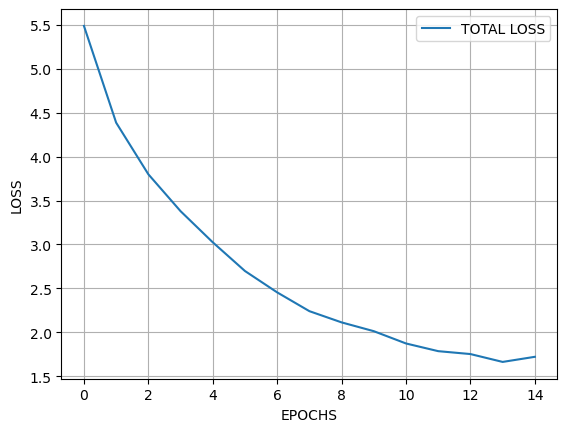

In [29]:

plt.plot(history.history['loss'], label='TOTAL LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.grid(True)
plt.show()
